In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
# 한글 쓰는 방법
import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = fm.FontProperties(fname=font_location).get_name()
print(font_name)
matplotlib.rc('font', family=font_name)
import os
# 현재 working directory 확인 방법
print(os.getcwd()) # 주피터에서
#pwd # 터미널에서 
# 데이터 있는 경로 확인
path = "/Users/jungtaekchoi/Google Drive/My Drive/fastcamp/datas"
# 경로 바꾸는 방법
os.chdir(path)
# 리스트 목록 확인
!ls

Apple SD Gothic Neo
/Volumes/GoogleDrive/My Drive/fastcamp/datas
Fastcampus_data_after_cleaning.csv
country.csv
sakila-data.sql
sakila-schema.sql
world.sql
수업.sql
수업2-2.sql
수업2.sql
데이터분석프로젝트_VER2_210329_210926.xlsx


/var/folders/k4/qhbh8yls6h349rdp_mfbt60w0000gn/T/ipykernel_49144/2293192428.py:9: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


### Part0. 문제정의 : 계절성 파악 및 원인 분석

In [13]:
df = pd.read_csv(path + "/Fastcampus_data_after_cleaning.csv")
df.dropna(inplace = True)

### Q1. 결재와 취소한 고객들

### Note : set 사용 
    - 중복 사라짐 --> 반복 결재에 대한 파악은 불가능.
    - 어떤 고객이 구매 취소했는지 파악에 집중

In [14]:
### 데이터 선택
complete = set(list(df[(df.type == "PAYMENT") & (df.state == "COMPLETED")].customer_id))
cancelled = set(list(df[(df.type == "PAYMENT") & (df.state == "CANCELLED")].customer_id))

In [15]:
### 차집합, 합집합 확인
complement = list((complete).difference(cancelled))
intersection = list(complete.intersection(cancelled))
print(f"차집합 : {len(complement)}")
print(f"합집합 : {len(intersection)}")

차집합 : 30971
합집합 : 2416


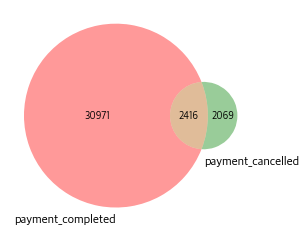

In [16]:
### 시각화
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted

set1 = set(complete)
set2 = set(cancelled)

venn2([set1, set2], ('payment_completed', 'payment_cancelled'))
plt.show()

### A1. 
    - 2416명이 구매 후 결재 취소 
    - 2069명의 구매 취소는 받은 데이터 이전에 구매한 사람이 취소한 것으로 이해된다.
    - 정확한 매출 파악을 위해 payment cancelled인 row 삭제 필요

In [17]:
complete_df = (df[(df.type == "PAYMENT") & (df.state == "COMPLETED")])
cancel_df = (df[(df.type == "PAYMENT") & (df.state == "CANCELLED")])

In [18]:
complete_df

,Unnamed: 0,id,customer_id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at
2,2,970657,72297.0,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090.0,190900.0,TOSS,CARD,없음,2021-03-04 00:00:00
4,4,970658,478028.0,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,117500.0,TOSS,CARD,PPT/보고서,2019-11-14 00:00:00
8,8,970669,478033.0,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,116000.0,TOSS,CARD,영상 편집,2020-12-02 00:00:00
10,10,970671,469860.0,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,없음,0.0,263000.0,TOSS,CARD,없음,2020-11-27 00:00:00
14,14,970676,478035.0,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,111000.0,TOSS,CARD,프론트엔드 개발,2021-02-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105387,105411,1364969,669238.0,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 3D 디자인 툴,디자인,올인원,2021-09-25 13:39:26,212000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.0,232000.0,INICIS,CARD,디자인툴,2021-04-23 00:00:00
105388,105412,1364976,384003.0,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-09-25 13:46:29,149000,없음,0.0,149000.0,KAKAO,CARD,영상 편집,2020-12-02 00:00:00
105389,105413,1364991,670891.0,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발,프로그래밍,올인원,2021-09-25 14:01:26,159000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.0,179000.0,INICIS,CARD,백엔드 개발,2021-05-31 00:00:00
105392,105416,1364996,640697.0,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기,영상/3D,올인원,2021-09-25 14:17:41,96000,[WELCOME] 온라인 강의 2만원 할인쿠폰,20000.0,116000.0,INICIS,VBANK,영상 편집,2021-06-15 00:00:00


In [19]:
# "customer_id", "course_title" 같은 경우 찾기
pd.merge(complete_df, cancel_df, on = ["customer_id", "course_title"], how='inner')
intersection_df = pd.merge(complete_df, cancel_df, on = ["customer_id", "course_title"], how='inner')
intersection_df.set_index("customer_id")

,Unnamed: 0_x,id_x,type_x,state_x,course_title,category_title_x,format_x,completed_at_x,transaction_amount_x,coupon_title_x,...,format_y,completed_at_y,transaction_amount_y,coupon_title_y,coupon_discount_amount_y,sale_price_y,pg_y,method_y,subcategory_title_y,marketing_start_at_y
customer_id,,,,,,,,,,,,,,,,,,,,,
490823.0,10869,1002901,PAYMENT,COMPLETED,올인원 패키지 : iOS 앱 개발,프로그래밍,올인원,2021-04-10 20:50:49,92000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,...,올인원,2021-09-13 12:24:33,92000,[재결제쿠폰]올인원 패키지 : iOS 앱 개발_2만원할인,20000.0,112000.0,NAVER,CASH,모바일앱,2020-01-14 00:00:00
87143.0,26473,1049313,PAYMENT,COMPLETED,올인원 패키지 : 바다가 알려주는 감성가득 영상 제작,영상/3D,올인원,2021-05-02 20:40:00,111000,없음,...,올인원,2021-08-05 17:10:59,129000,없음,0.0,129000.0,INICIS,TRANS,영상 편집,2021-03-19 00:00:00
544152.0,44031,1107775,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 디자인 툴,디자인,올인원,2021-05-30 18:23:27,144000,[웰컴쿠폰] 올인원 패키지 3만원 할인 쿠폰,...,올인원,2021-08-24 19:28:28,180000,없음,0.0,180000.0,INICIS,TRANS,디자인툴,2020-12-24 11:00:00
496186.0,45472,1111584,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-05-31 18:15:47,95000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,...,올인원,2021-08-08 10:16:31,156000,없음,0.0,156000.0,NAVER,CASH,프론트엔드 개발,2021-02-02 00:00:00
560778.0,60411,1164117,PAYMENT,COMPLETED,올인원 패키지 : 아카데미 : 편집하는여자의 영상편집 마스터클래스 - 제 1강 프리...,영상/3D,올인원,2021-06-25 11:02:21,88000,없음,...,올인원,2021-06-14 15:11:58,98000,없음,0.0,98000.0,INICIS,VBANK,영상 편집,2021-06-03 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670621.0,105338,1364638,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발,프로그래밍,올인원,2021-09-25 00:32:50,179000,없음,...,올인원,2021-09-25 00:29:38,169000,[미래투자금] 온라인 강의 1만원 할인쿠폰,10000.0,179000.0,INICIS,CARD,백엔드 개발,2021-05-31 00:00:00
646968.0,105354,1364702,PAYMENT,COMPLETED,올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...,디자인,올인원,2021-09-25 02:37:22,149000,[WELCOME] 온라인 강의 2만원 할인쿠폰,...,올인원,2021-09-25 02:30:51,149000,[WELCOME] 온라인 강의 2만원 할인쿠폰,20000.0,169000.0,KAKAO,CASH,UX/UI,2021-08-23 00:00:00
670817.0,105395,1364875,PAYMENT,COMPLETED,초격차 패키지 : 30개 프로젝트로 배우는 Android 앱 개발 with Kotlin,프로그래밍,올인원,2021-09-25 11:29:36,172000,없음,...,올인원,2021-09-25 11:28:54,172000,없음,0.0,172000.0,INICIS,CARD,모바일앱,2021-02-25 00:00:00


In [27]:
complete_df2 = complete_df.set_index("customer_id").drop(intersection_df.customer_id)
complete_df2 = complete_df2.reset_index()

In [35]:
complete_df2

,customer_id,Unnamed: 0,id,type,state,course_title,category_title,format,completed_at,transaction_amount,coupon_title,coupon_discount_amount,sale_price,pg,method,subcategory_title,marketing_start_at
0,72297.0,2,970657,PAYMENT,COMPLETED,시크릿코드 : 프론트엔드 실무 완성편,프로그래밍,스쿨 온라인,2021-03-28 15:21:43,171810,[10% 할인] 시크릿코드 실무 완성편,19090.0,190900.0,TOSS,CARD,없음,2021-03-04 00:00:00
1,478028.0,4,970658,PAYMENT,COMPLETED,올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX,업무 생산성,올인원,2021-03-28 15:21:54,97500,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,117500.0,TOSS,CARD,PPT/보고서,2019-11-14 00:00:00
2,478033.0,8,970669,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-03-28 15:26:47,96000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,116000.0,TOSS,CARD,영상 편집,2020-12-02 00:00:00
3,469860.0,10,970671,PAYMENT,COMPLETED,올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장),부동산/금융,올인원,2021-03-28 15:27:17,263000,없음,0.0,263000.0,TOSS,CARD,없음,2020-11-27 00:00:00
4,478035.0,14,970676,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 프론트엔드 개발,프로그래밍,올인원,2021-03-28 15:31:01,91000,[웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰,20000.0,111000.0,TOSS,CARD,프론트엔드 개발,2021-02-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40639,585941.0,105401,1364901,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터,프로그래밍,올인원,2021-09-25 11:59:42,179000,없음,0.0,179000.0,INICIS,CARD,백엔드 개발,2021-02-01 00:00:00
40640,669238.0,105411,1364969,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 3D 디자인 툴,디자인,올인원,2021-09-25 13:39:26,212000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.0,232000.0,INICIS,CARD,디자인툴,2021-04-23 00:00:00
40641,384003.0,105412,1364976,PAYMENT,COMPLETED,초격차 패키지 : 한번에 끝내는 영상 촬영과 편집,영상/3D,올인원,2021-09-25 13:46:29,149000,없음,0.0,149000.0,KAKAO,CARD,영상 편집,2020-12-02 00:00:00
40642,670891.0,105413,1364991,PAYMENT,COMPLETED,초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발,프로그래밍,올인원,2021-09-25 14:01:26,159000,[미래투자금] 온라인 강의 2만원 할인쿠폰,20000.0,179000.0,INICIS,CARD,백엔드 개발,2021-05-31 00:00:00
